# Práctica 2

In [1]:
import pandas as pd 
import numpy as np 
import random
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

## Detección de Anomalías

Usando el dataset de estaturas aplicar detección de anomalías

1. Usar como training-set la primera pestaña de "normales" (y = 0 o sin anomalías)

2. La segunda pestaña "valtest(normales)" contiene datos normales (y = 0 / sin anomalías)

    - Usar la mitad para cross-validation
    - Usar la mitad para testing
    
<br>

3. La tercera pestaña "valtest(anomalías)" contiene anomalías (y = 1)

    - Usar la mitad para cross-validation
    - Usar la mitad para testing


In [2]:
# Se cargan los datos de "estaturas.xlsx"
dfs = pd.read_excel("estaturas.xlsx", sheet_name = None)

# Se obtienen los datos de "entrenamiento"
train_data = dfs["normales"]

# Se obtienen los datos de prueba con y sin anomalías
valtest_data_pos = dfs["anomalias"]
valtest_data_neg = dfs["valtest(normales)"]

# Se cambian los nombres de las columnas en los valores negativos
valtest_data_neg = valtest_data_neg.set_axis(["Estatura", "Edad"], axis=1)

# Se "shufflean" las filas de los dos dataframes
valtest_data_pos = valtest_data_pos.sample(frac=1).reset_index(drop=True)
valtest_data_neg = valtest_data_neg.sample(frac=1).reset_index(drop=True)

# La primera mitad de los valores se utilizan para validación
val_data_pos = valtest_data_pos.iloc[:len(valtest_data_pos)//2, :]
val_data_neg = valtest_data_neg.iloc[:len(valtest_data_neg)//2, :]
val_data = pd.concat([val_data_pos, val_data_neg])

# La segunda mitad de los valores se utilizan para test
test_data_pos = valtest_data_pos.iloc[len(valtest_data_pos)//2 :, :]
test_data_neg = valtest_data_neg.iloc[len(valtest_data_neg)//2 :, :]
test_data = pd.concat([test_data_pos, test_data_neg])

# Arrays con los valores reales de "atípico o no atípico"
y_true = np.zeros((len(val_data), 1))
y_true[0:len(valtest_data_pos)//2] = 1

# Se incluyen las columnas de labels 
val_data = val_data.assign(Anomalia_True = y_true)
test_data = test_data.assign(Anomalia_True = y_true)

# Se realiza una última "shuffleada" a los datos de prueba y validación
val_data = val_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

Creación de una función de distribución de probabilidad a partir de los datos de entrenamiento, así como una función que retorna la probabilidad de una observación utilizando la media y desviación estándar de dicha distribución. 

In [3]:
# Entrenamiento de modelo (extracción de media y covarianza)
def createDistribution(data):

    # Vector de medias (Dims: 1 x NoVars)
    mu = np.mean(data, axis=0).to_numpy()

    # Matriz de covarianzas (Dims: NoVars x NoVars)
    sigma = np.cov(data.T)

    return mu, sigma

# Función que retorna la probabilidad correspondiente a una muestra
def predictDistribution(mu, sigma, data):

    from scipy.stats import multivariate_normal

    dist = multivariate_normal(mean = mu, cov = sigma)

    return dist.pdf(data)

Se entrena (crea una distribución normal multidimensional) un modelo utilizando la función creada y luego se realiza una predicción de la probabilidad de diferentes muestras propias del dataset de validación.

In [4]:
# Se entrena el modelo
modelo = createDistribution(train_data)

# Se generan predicciones o probabilidades utilizando el dataset de validación
probs = predictDistribution(modelo[0], modelo[1], val_data[["Estatura", "Edad"]])

# Se presentan los resultados
print(val_data.assign(Probabilidades = probs))

   Estatura   Edad  Anomalia_True  Probabilidades
0      1.60     31            0.0        0.060092
1      1.79     31            0.0        0.232738
2      0.25  43557            1.0        0.000000
3      1.60     35            0.0        0.038381
4    150.00     14            1.0        0.000000
5      1.76     32            0.0        0.275183


Según los resultados anteriores, parece que un umbral adecuado para la clasificación sería un valor muy cercano a 0. Por lo tanto, tomando en cuenta que uno de los valores "no atípicos" parece contar con una probabilidad de 0.075, se utilizará un umbral con un valor menor a este número: 0.0005. Debido a que la clasificación es fácilmente conseguida utilizando un umbral simple, no se considera apropiado utilizar una transformación de ningún tipo.

In [5]:
epsilon = 0.0005

Se utiliza el umbral anterior para poder realizar la detección de valores atípicos en el dataset de prueba. Con los resultados obtenidos se calcula el F1 Score

In [6]:
# Se obtienen las probabilidades para cada observación de prueba
probs = predictDistribution(modelo[0], modelo[1], test_data[["Estatura", "Edad"]])

# Se detectan valores atípicos
preds = (probs < epsilon).astype(int)

# Se guardan los resultados en un nuevo dataframe
results = test_data.assign(Anomalia_Pred = preds, Probabilidades = probs)

# Se despliegan los resultados
print(results)

# Se calcula el f1-score de las predicciones
from sklearn.metrics import f1_score
f1 = f1_score(results["Anomalia_True"], results["Anomalia_Pred"])
print("F1 Score:", f1)


   Estatura   Edad  Anomalia_True  Anomalia_Pred  Probabilidades
0      1.61     31            0.0              0        0.075409
1      1.82     30            0.0              0        0.162041
2      1.82     25            0.0              0        0.114253
3      0.15    250            1.0              1        0.000000
4      1.80     27            0.0              0        0.185247
5    175.10  43587            1.0              1        0.000000
F1 Score: 1.0


Dado que se obtuvo un F1 Score de 1, se considera que, al menos para el dataset limitado con el que se contaba, el modelo de detección de anomalías es exitoso. 

--------

## Reducción de Dimensionalidad

Usando el dataset de "fashion MNIST" realizar:

1. PCA sin sci-kit learn para reducir a 2 dimensiones. Anotar la cantidad de varianza preservada.

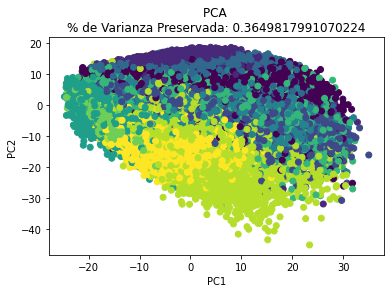

In [59]:
# Se carga el dataset
from keras.datasets import fashion_mnist
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

# Se aplanan las features de entrenamiento
trainX = np.reshape(trainX, (-1, trainX.shape[1] * trainX.shape[2]))

# Se normalizan / escalan los datos
trainX_norm = (trainX - np.mean(trainX, axis = 0)) / np.std(trainX, axis = 0)

# Se calcula la matriz de covarianza
cov_matrix = np.cov(trainX_norm.T)

# Se calculan los eigenvectores y eigenvalores
eig_val, eig_vec = np.linalg.eig(cov_matrix)

# Se calcula el porcentaje de varianza preservada para cada PC
var_preservada = []
for i in range(len(eig_val)):
    var_preservada.append(eig_val[i] / np.sum(eig_val))

# Parece que los dos primeros componentes preservan la mayor cantidad de varianza
# Se proyectan los datos hacia los primeros dos componentes
pc1 = trainX_norm.dot(eig_vec.T[0])
pc2 = trainX_norm.dot(eig_vec.T[1])

# Se juntan los dos componentes principales en un solo array
pc1 = np.reshape(pc1, (-1, 1))
pc2 = np.reshape(pc2, (-1, 1))
trainX_pca = np.hstack((pc1, pc2))

# Se visualiza la reducción
plt.scatter(pc1, pc2, c=trainY, cmap = "viridis")
plt.title(f"PCA \n% de Varianza Preservada: {np.sum(var_preservada[0:2])}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

2. T-SNE con sci-kit learn para reducir a 2 dimensiones.

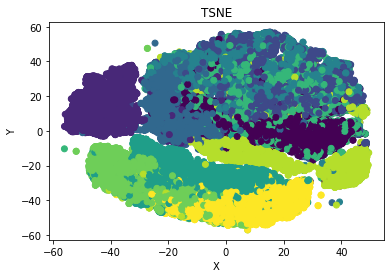

In [41]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Previo a aplicar TSNE se aplica PCA para reducir a 50 dimensiones
# De esta manera se reduce el tiempo de optimización
#trainX_pca = PCA(n_components=50).fit_transform(trainX) 

# Se realiza la reducción con TSNE
trainX_tsne = TSNE(n_components = 2).fit_transform(trainX)
trainX_tsne.shape

# Se visualiza la reducción
plt.scatter(trainX_tsne[:,0], trainX_tsne[:,1], c=trainY, cmap = "viridis")
plt.title(f"TSNE")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

3. Analizar ambas representaciones, comparar y concluir.

- Los datasets con reducción de dimensionalidad se graficaron por separado y se pudo llegar a observar que los resultados obtenidos con PCA fueron mucho peores que aquellos obtenidos a través de TSNE. El porcentaje de varianza preservada con el método de PCA era muy baja al mantener únicamente 2 componentes (menor al 40%), lo que causó que los datos no presentaran separaciones claras (todos parecen formar parte de un mismo conjunto grande). Por otro lado, TSNE parece crear separaciones mucho más evidentes entre datos. Al corroborar si estas separaciones eran correctas al "colorear cada clase de un color diferente" se pudo llegar a evidenciar que efectivamente TSNE consiguió agrupar de mejor manera las clases reales (aunque no perfectamente), contrario a PCA que parece haber combinado todas.

4. Aplicar clustering con sci-kit learn sobre la representación reducida.

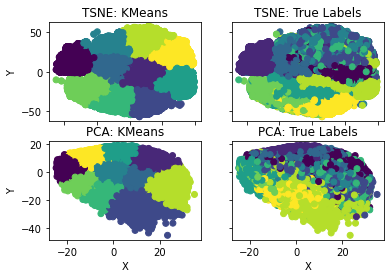

In [64]:
from sklearn.cluster import KMeans

# Se determina el número de clases únicas del dataset
n_classes = len(np.unique(trainY))

# Se aplica clustering
pred_classes_tsne = KMeans(n_clusters=n_classes).fit_predict(trainX_tsne)
pred_classes_pca = KMeans(n_clusters=n_classes).fit_predict(trainX_pca)

# Se crea un subplot de 2x2
f, axarr = plt.subplots(2,2)

# Se visualiza la reducción
axarr[0,0].scatter(trainX_tsne[:,0], trainX_tsne[:,1], c=pred_classes_tsne, cmap = "viridis")
axarr[0,0].set_title(f"TSNE: KMeans")
axarr[0,1].scatter(trainX_tsne[:,0], trainX_tsne[:,1], c=trainY, cmap = "viridis")
axarr[0,1].set_title(f"TSNE: True Labels")
axarr[1,0].scatter(pc1, pc2, c=pred_classes_pca, cmap = "viridis")
axarr[1,0].set_title(f"PCA: KMeans")
axarr[1,1].scatter(pc1, pc2, c=trainY, cmap = "viridis")
axarr[1,1].set_title(f"PCA: True Labels")

# Solo se incluyen las X y Y labels para los plots extremos
for ax in axarr.flat:
    ax.set(xlabel='X', ylabel='Y')

# Se eliminan los ticks entre gráficas, solo se mantienen los ticks extremos
for ax in axarr.flat:
    ax.label_outer()

plt.show()

5. Ya que este dataset si posee etiquetas "y" (tipo de prenda) analizar si los clusters encontrados tienden a agrupar el mismo tipo de prenda o prendas similares.

- Al comparar las clasificaciones utilizando KMeans y las etiquetas verdaderas, se puede llegar a nuevamente comprobar lo que se mencionó previamente en el punto 3: La separación utilizando TSNE, aunque presenta errores, presenta una mucho mejor segregación entre clases, a comparación de PCA, donde los resultados obtenidos utilizando KMeans no se asemejan en lo absoluto a las separaciones reales entre clases. En TSNE, algunos de los clusters obtenidos utilizando KMeans son casi idénticos a los clusters observados al separar los datos utilizando las etiquetas reales, lo que evidencia que TSNE resultó en una reducción de dimensionalidad más efectiva y útil.

6. Agregar conclusiones finales.

- En conclusión, TSNE parece consistir de un método mucho más efectivo para reducir la dimensionalidad de problemas altamente dimensionales, a comparación de PCA. No obstante, debido a que PCA únicamente hace uso de álgebra lineal para obtener sus resultados, este consiste de un método mucho más rápido a comparación TSNE, el cual incrementa el tiempo de computación de manera sustancial a medida que utiliza más observaciones. Por lo tanto, al momento de realizar reducción de dimensionalidad se debe elegir entre efectividad y velocidad, aunque al unir ambos métodos se pueden obtener mejoras. [Tyler Folkman](https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0), por ejemplo, sugiere aplicar primero PCA para reducir a 50 dimensiones problemas con dimensionalidades arriba de 50, y posterior a esto utilizar TSNE para llegar a una cantidad de dimensiones visualizable (2 o 3). De esta manera se aprovecha la efectividad de TSNE, pero reduciendo ligeramente el tiempo de computación.
